# post ace, alpha genome

In [1]:
#let's load this in and compare

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import zarr


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2



qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

def predict_snp_effect_scores_bpnet(ref_prob_preds, alt_prob_preds, ref_count_preds, alt_count_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    
    print(ref_prob_preds.shape, alt_prob_preds.shape, ref_count_preds.shape, alt_count_preds.shape)
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    #and account for nan
    log_probs_diff_abs_sum[np.isnan(log_probs_diff_abs_sum)] = 0
    # probs_jsd_diff = np.array([jensenshannon(softmax(x),softmax(y)) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    probs_jsd_diff = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(alt_prob_preds),
                                    softmax(ref_prob_preds))])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_count_preds/alt_count_preds)[:,0]
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2
    
labels = qtls['label'].to_numpy()

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'green', 'brown', 'gray', 'purple', 'pink', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        elif file.endswith('zarr'):
            eqtl_data = zarr.open(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=9,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()



(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_897004/1201625447.py:98: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


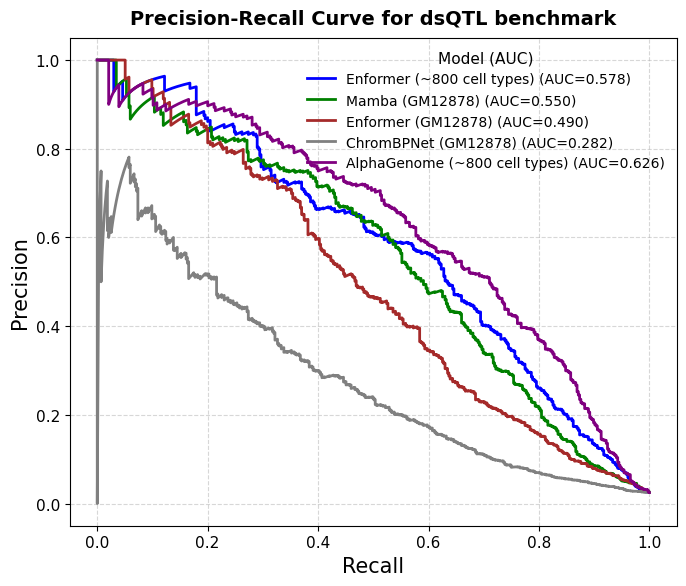

In [3]:
files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'enformer_dsqtl_retrained-dsqtl.npy', '.npz', 'alphagenome_dsqtl.zarr']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Enformer (GM12878)', 'ChromBPNet (GM12878)', 'AlphaGenome (~800 cell types)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_241375/4159107463.py:98: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


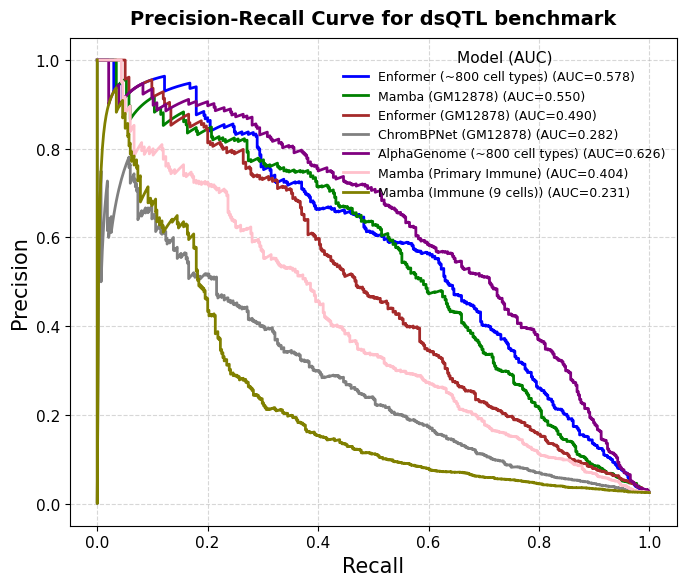

In [8]:
#let's also add in the fully pretrained model!

files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'enformer_dsqtl_retrained-dsqtl.npy', '.npz', 'alphagenome_dsqtl.zarr', 'primary_immune.npy', 'immune_all_2.npy']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Enformer (GM12878)', 'ChromBPNet (GM12878)', 'AlphaGenome (~800 cell types)', 'Mamba (Primary Immune)', 'Mamba (Immune (9 cells))']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

In [ ]:
#so this is interesting, basically it's better here for primary immune than other things... hmmmmmmm
#much better than the one pretrained on a subset of cell types...


# and let's redo it with the model with less folds

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_1814203/4159107463.py:98: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


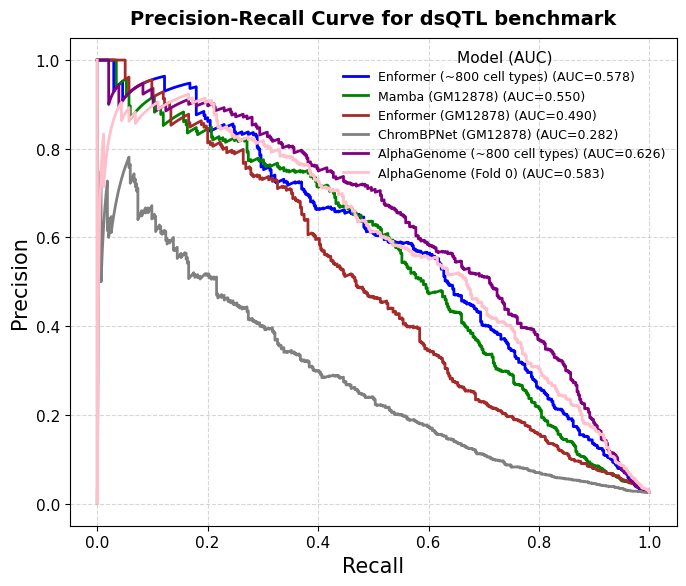

In [2]:
files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'enformer_dsqtl_retrained-dsqtl.npy', '.npz', 'alphagenome_dsqtl.zarr', 'alphagenome_dsqtl_fold0.zarr']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Enformer (GM12878)', 'ChromBPNet (GM12878)', 'AlphaGenome (~800 cell types)', 'AlphaGenome (Fold 0)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

In [ ]:
#ahh now it performs much worse?? Hmmmm, seems this distillation is very important!!